In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
window_size_ms = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [339]:
dataset = "dataPixelRHandStandingRandom"
with open(dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    print(next(csvreader))
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'accelerometer', '1556846706990', '0.023820243775844574', '0.19748443365097046', '0.9562157988548279']
['-2.0', '-2.0', 'gyroscope', '1556846706994', '0.00787353515625', '0.108367919921875', '0.057403564453125']
Total time (s):  216.937


In [340]:
def normalize(arr):
    """Normalizes to [-1, 1]."""
    arr_min = np.min(arr, axis=0)
    arr_range = np.ptp(arr, axis=0)
    print("Min: ", arr_min)
    print("Range: ", arr_range)
    return (2.*(arr - arr_min) / arr_range) - 1

normalize(np.array([[100, 5, 1],[200, 6, 0],[150, 0,100]]))

Min:  [100   0   0]
Range:  [100   6 100]


array([[-1.        ,  0.66666667, -0.98      ],
       [ 1.        ,  1.        , -1.        ],
       [ 0.        , -1.        ,  1.        ]])

In [341]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size_ms))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Min:  [-0.88349003 -0.21655588 -0.98441917]
Range:  [1.30648491 1.15038292 2.63483113]
Min:  [-2.22851562 -3.23796082 -1.67318726]
Range:  [4.85092163 7.8894043  3.61878967]
Total time:  216937.0
Num windows: 1085
Num samples:  21700


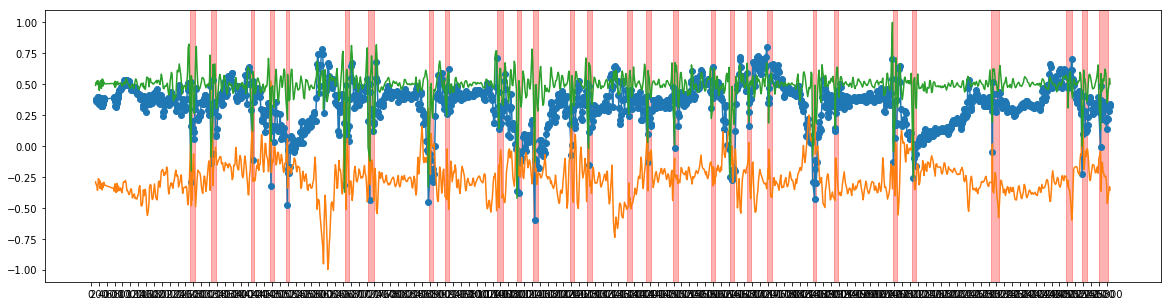

In [342]:
plt.figure(figsize=(20,5))

num_samples_to_view = 1500
plot_end_time = acc_data[num_samples_to_view - 1][0]
acc_data_t_ms = acc_data[:num_samples_to_view, 0]
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 1], marker="o")
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 2])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < plot_end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < plot_end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, plot_end_time, step=200))
plt.show()

(3, 21700)
Done.


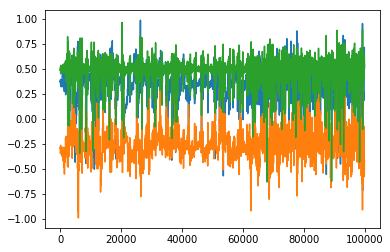

In [343]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

num_samples_to_view = 10000
acc_data_interp = np.array(acc_data_interp)
print(acc_data_interp.shape)
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[0, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[1, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[2, :num_samples_to_view])

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

In [344]:
# Collect touch labels
# has_touch = 1 if there is a touch ONSET in that window
# TODO: might want to test this assumption

# (# presses, 3) array of (window #, touch_x, touch_y)
press_locs = np.array([[
    int(math.floor((int(x[3]) - start_time) / window_size_ms)), float(x[0]), float(x[1])
] for x in csvf if x[2] == "press"])

has_touch = -1 * np.ones((num_windows,))
touch_loc = -2 * np.ones((num_windows, 2))

has_touch[press_locs[:,0].astype(int)] = 1
touch_loc[press_locs[:,0].astype(int)] = press_locs[:,1:]
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Min:  [-2. -2.]
Range:  [345.42855835 622.8571167 ]
Number touch windows 427
Number no touch windows 658


/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


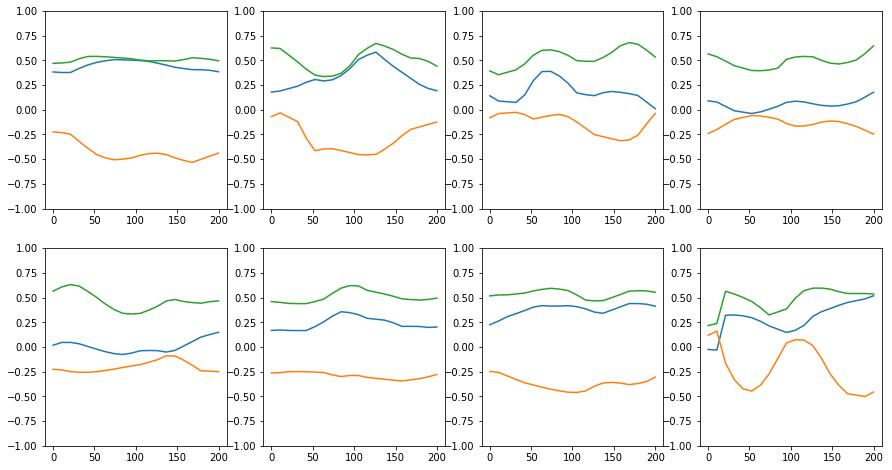

In [345]:
# Visualize touch / no touch windows
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == -1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


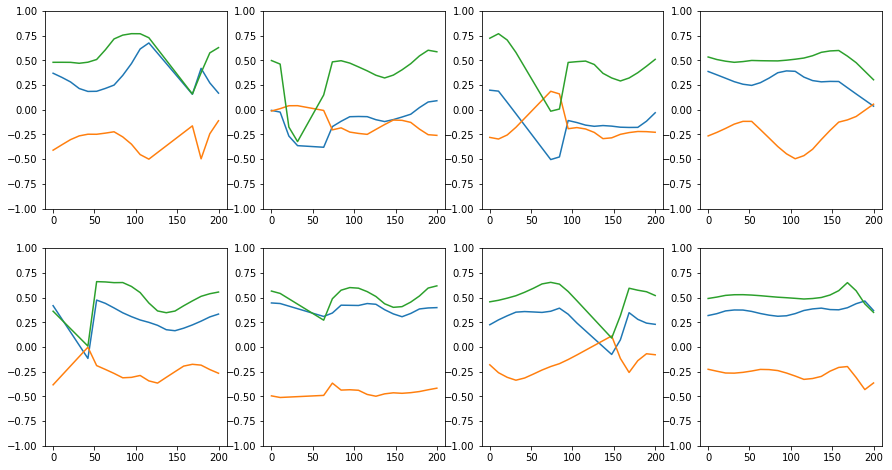

In [346]:
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == 1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

In [347]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (1085, 120)
has_touch:  (1085,)
touch_loc:  (1085, 2)


# ~ machine learning ~

In [131]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from keras import regularizers

In [147]:
X_balanced = np.load("processed/balanced_combined_X.npy")
has_touch_y_balanced = np.load("processed/balanced_combined_has_touch_y.npy")
X_balanced = X_balanced.reshape((-1, 120))
has_touch_y_balanced = (has_touch_y_balanced + 1)/2

In [148]:
def visualize_classes(X, y, class_lbl, title=""):
    nrows = 8
    ncols = 8
    X = X.reshape((-1, samples_per_window, 6))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.reshape(-1)

    count = 0
    for i in range(50,len(y)):
        if y[i] == class_lbl:
            if count == nrows * ncols: break
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,0])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,1])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,2])
            axes[count].set_ylim(-1, 1)
            count += 1
    fig.suptitle(title)
    fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


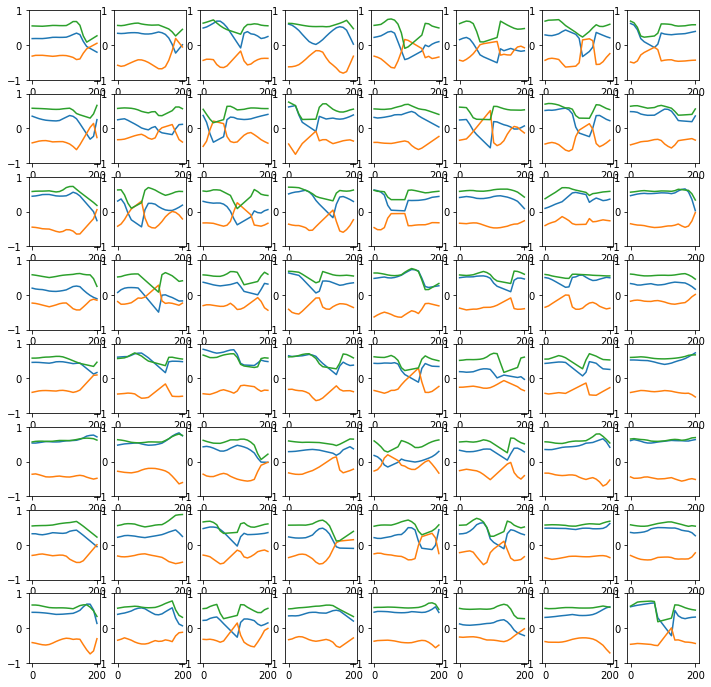

In [149]:
visualize_classes(X_balanced, has_touch_y_balanced, 1)

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


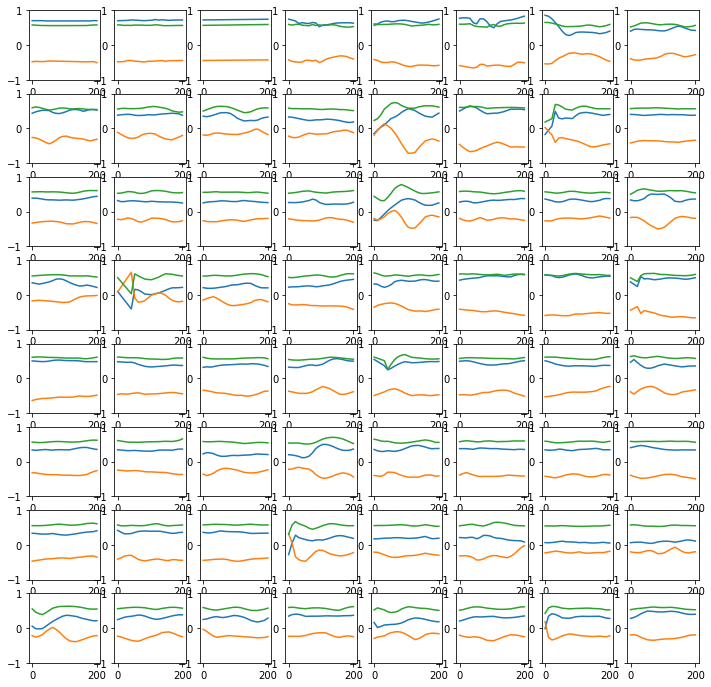

In [150]:
visualize_classes(X_balanced, has_touch_y_balanced, 0)

In [151]:
def build_model():
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=(samples_per_window * 6)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.003)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-4), metrics = ["accuracy"])
    return model

In [152]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)

In [153]:
seed = 0

accs = []
histories = []

for train_idx, test_idx in skf.split(X_balanced, has_touch_y_balanced):
    x_train, x_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = has_touch_y_balanced[train_idx], has_touch_y_balanced[test_idx]
    
    model = build_model()
    
    history = model.fit(x_train, y_train, epochs=75, batch_size=20, validation_data=(x_test, y_test))
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)
    histories.append(history)

Train on 992 samples, validate on 250 samples
Epoch 1/75
992/992 [==============================] - 0s - loss: 0.9213 - acc: 0.6643 - val_loss: 0.8978 - val_acc: 0.6400
Epoch 2/75
992/992 [==============================] - 0s - loss: 0.8699 - acc: 0.7268 - val_loss: 0.8420 - val_acc: 0.7960
Epoch 3/75
992/992 [==============================] - 0s - loss: 0.8114 - acc: 0.8286 - val_loss: 0.7804 - val_acc: 0.8040
Epoch 4/75
992/992 [==============================] - 0s - loss: 0.7481 - acc: 0.8296 - val_loss: 0.7121 - val_acc: 0.8320
Epoch 5/75
992/992 [==============================] - 0s - loss: 0.6865 - acc: 0.8377 - val_loss: 0.6522 - val_acc: 0.8480
Epoch 6/75
992/992 [==============================] - 0s - loss: 0.6281 - acc: 0.8498 - val_loss: 0.6075 - val_acc: 0.8480
Epoch 7/75
992/992 [==============================] - 0s - loss: 0.5893 - acc: 0.8569 - val_loss: 0.5853 - val_acc: 0.8200
Epoch 8/75
992/992 [==============================] - 0s - loss: 0.5593 - acc: 0.8569 - val_l

992/992 [==============================] - 0s - loss: 0.2153 - acc: 0.9385 - val_loss: 0.3836 - val_acc: 0.8760
Epoch 67/75
992/992 [==============================] - 0s - loss: 0.2151 - acc: 0.9415 - val_loss: 0.3840 - val_acc: 0.8800
Epoch 68/75
992/992 [==============================] - 0s - loss: 0.2088 - acc: 0.9435 - val_loss: 0.3914 - val_acc: 0.8800
Epoch 69/75
992/992 [==============================] - 0s - loss: 0.2086 - acc: 0.9425 - val_loss: 0.3839 - val_acc: 0.8800
Epoch 70/75
992/992 [==============================] - 0s - loss: 0.2029 - acc: 0.9415 - val_loss: 0.3944 - val_acc: 0.8760
Epoch 71/75
992/992 [==============================] - 0s - loss: 0.2025 - acc: 0.9425 - val_loss: 0.3858 - val_acc: 0.8800
Epoch 72/75
992/992 [==============================] - 0s - loss: 0.2010 - acc: 0.9446 - val_loss: 0.3859 - val_acc: 0.8760
Epoch 73/75
992/992 [==============================] - 0s - loss: 0.1994 - acc: 0.9425 - val_loss: 0.3830 - val_acc: 0.8760
Epoch 74/75
992/992 

994/994 [==============================] - 0s - loss: 0.2482 - acc: 0.9296 - val_loss: 0.3612 - val_acc: 0.8871
Epoch 57/75
994/994 [==============================] - 0s - loss: 0.2456 - acc: 0.9296 - val_loss: 0.3583 - val_acc: 0.8871
Epoch 58/75
994/994 [==============================] - 0s - loss: 0.2395 - acc: 0.9306 - val_loss: 0.3663 - val_acc: 0.8831
Epoch 59/75
994/994 [==============================] - 0s - loss: 0.2354 - acc: 0.9306 - val_loss: 0.3584 - val_acc: 0.8952
Epoch 60/75
994/994 [==============================] - 0s - loss: 0.2311 - acc: 0.9296 - val_loss: 0.3721 - val_acc: 0.8831
Epoch 61/75
994/994 [==============================] - 0s - loss: 0.2322 - acc: 0.9326 - val_loss: 0.3655 - val_acc: 0.8871
Epoch 62/75
994/994 [==============================] - 0s - loss: 0.2274 - acc: 0.9376 - val_loss: 0.3588 - val_acc: 0.8911
Epoch 63/75
994/994 [==============================] - 0s - loss: 0.2272 - acc: 0.9396 - val_loss: 0.3568 - val_acc: 0.8911
Epoch 64/75
994/994 

994/994 [==============================] - 0s - loss: 0.2767 - acc: 0.9225 - val_loss: 0.3090 - val_acc: 0.9113
Epoch 47/75
994/994 [==============================] - 0s - loss: 0.2737 - acc: 0.9195 - val_loss: 0.3073 - val_acc: 0.9073
Epoch 48/75
994/994 [==============================] - 0s - loss: 0.2722 - acc: 0.9225 - val_loss: 0.3062 - val_acc: 0.9073
Epoch 49/75
994/994 [==============================] - 0s - loss: 0.2667 - acc: 0.9235 - val_loss: 0.3047 - val_acc: 0.9073
Epoch 50/75
994/994 [==============================] - 0s - loss: 0.2650 - acc: 0.9276 - val_loss: 0.3056 - val_acc: 0.9113
Epoch 51/75
994/994 [==============================] - 0s - loss: 0.2612 - acc: 0.9245 - val_loss: 0.3057 - val_acc: 0.9073
Epoch 52/75
994/994 [==============================] - 0s - loss: 0.2595 - acc: 0.9266 - val_loss: 0.3036 - val_acc: 0.9032
Epoch 53/75
994/994 [==============================] - 0s - loss: 0.2563 - acc: 0.9326 - val_loss: 0.3015 - val_acc: 0.9032
Epoch 54/75
994/994 

994/994 [==============================] - 0s - loss: 0.3270 - acc: 0.9074 - val_loss: 0.3775 - val_acc: 0.8710
Epoch 37/75
994/994 [==============================] - 0s - loss: 0.3266 - acc: 0.9044 - val_loss: 0.3769 - val_acc: 0.8669
Epoch 38/75
994/994 [==============================] - 0s - loss: 0.3187 - acc: 0.9095 - val_loss: 0.3716 - val_acc: 0.8669
Epoch 39/75
994/994 [==============================] - 0s - loss: 0.3164 - acc: 0.9085 - val_loss: 0.3706 - val_acc: 0.8669
Epoch 40/75
994/994 [==============================] - 0s - loss: 0.3150 - acc: 0.9105 - val_loss: 0.3660 - val_acc: 0.8831
Epoch 41/75
994/994 [==============================] - 0s - loss: 0.3124 - acc: 0.9034 - val_loss: 0.3643 - val_acc: 0.8710
Epoch 42/75
994/994 [==============================] - 0s - loss: 0.3030 - acc: 0.9175 - val_loss: 0.3619 - val_acc: 0.8710
Epoch 43/75
994/994 [==============================] - 0s - loss: 0.3039 - acc: 0.9145 - val_loss: 0.3658 - val_acc: 0.8710
Epoch 44/75
994/994 

994/994 [==============================] - 0s - loss: 0.3519 - acc: 0.8944 - val_loss: 0.4543 - val_acc: 0.8427
Epoch 27/75
994/994 [==============================] - 0s - loss: 0.3439 - acc: 0.8954 - val_loss: 0.4495 - val_acc: 0.8589
Epoch 28/75
994/994 [==============================] - 0s - loss: 0.3416 - acc: 0.9044 - val_loss: 0.4456 - val_acc: 0.8589
Epoch 29/75
994/994 [==============================] - 0s - loss: 0.3371 - acc: 0.8863 - val_loss: 0.4688 - val_acc: 0.8508
Epoch 30/75
994/994 [==============================] - 0s - loss: 0.3308 - acc: 0.9004 - val_loss: 0.4369 - val_acc: 0.8548
Epoch 31/75
994/994 [==============================] - 0s - loss: 0.3248 - acc: 0.9064 - val_loss: 0.4689 - val_acc: 0.8508
Epoch 32/75
994/994 [==============================] - 0s - loss: 0.3262 - acc: 0.9004 - val_loss: 0.4297 - val_acc: 0.8548
Epoch 33/75
994/994 [==============================] - 0s - loss: 0.3121 - acc: 0.9004 - val_loss: 0.4288 - val_acc: 0.8589
Epoch 34/75
994/994 

In [154]:
print(accs)
np.mean(accs)

[0.8719999985694885, 0.891129034180795, 0.9032258045288825, 0.9112903206579147, 0.875]


0.8905290315874161

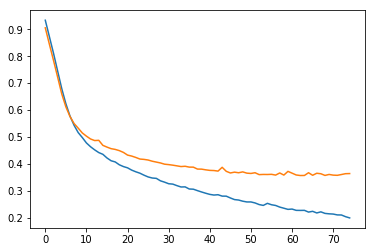

In [155]:
plt.plot(histories[1].history["loss"])
plt.plot(histories[1].history["val_loss"])

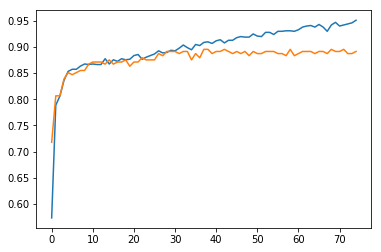

In [156]:
plt.plot(histories[1].history["acc"])
plt.plot(histories[1].history["val_acc"])